In [5]:
# Initialize Otter
import otter
grader = otter.Notebook("lab_freqresprclp2023.ipynb")

# Assignment

***
**Task**:  Investigate and explore the properties of a first-order highpass filter, relating the time domain and the frequency domain responses.
***

A first-order highpass RC filter is governed by the differential equation
$$y(t) + RC \frac{dy(t)}{dt} = RC \frac{dx(t)}{dt},$$
where $x(t)$ is the input and $y(t)$ is the output.  

Discretising using the standard Euler method (with forward differences) the forward and reverse iterations can be shown to be
$$
y[n+1] \approx (1 - T/(RC)) y[n] + x[n+1] - x[n] \qquad \text{and} \qquad
y[n-1] \approx \frac{1}{1-T/(RC)} ( y[n] - x[n] + x[n-1] ),
$$
where $x[n] = x(nT)$ and $y[n] = y(nT)$.  Smaller values of $T$ lead to better approximations but increase the computation required.

The function `rchighpass_resp` below takes a vector `xv` of sampled input signal values $x[0], \ldots, x[N-1]$, the quantities `n0` and `y0` defining the auxiliary output condition `yv[n0] = y0`, a parameter value `RC`, and an approximation step size $T$, and outputs the vector `yv` containing the corresponding output values $y[0], \ldots, y[N-1]$.  Add code as required to implement the forward and reverse recursions from the time index defined by the auxiliary condition.

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def rchighpass_resp(xv,n0,y0,RC,T):
    """RC highpass output from given input using standard Euler 
    xv:  input signal (array)
    n0, y0:  auxiliary condition yv[n0] = y0
    RC:  parameter values
    T:  Euler step size for numerical approximation
    returns yv:  output signal (array)
    """

    # Initialise
    yv = np.zeros(xv.shape,dtype=xv.dtype)
    yv[n0] = y0;
    TdRC = T/RC;
    
    # Standard Euler in forward direction
    for n in range(n0,len(xv)-1):
        yv[n+1] = (1-TdRC)*yv[n]+xv[n+1]-xv[n]

    # Standard Euler in reverse direction
    for n in range(n0,0,-1):
        yv[n-1] = 1/(1-TdRC)*(yv[n]-xv[n]+xv[n-1])

    return yv;

In [7]:
grader.check("freqresprclp_q1a")

freqresprclp_q1a results: All test cases passed!
freqresprclp_q1a - 1 message: forward iteration gives correct values for simple test case
freqresprclp_q1a - 2 message: reverse iteration gives correct values for simple test case

***

We can use the function above to estimate the impulse response as follows.  Note that for the auxilliary condition we assume initial rest, with an output value equal to zero very far into the past.

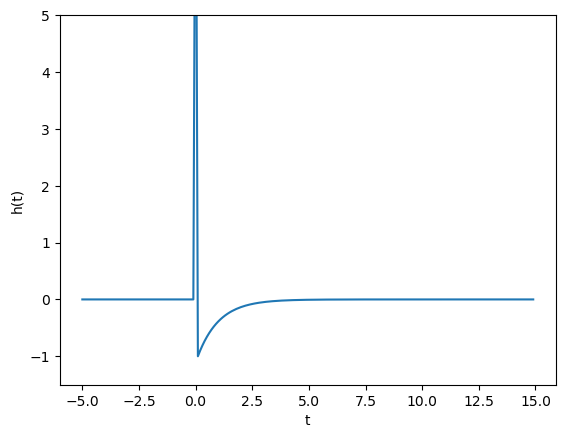

In [8]:
# Constants defining the differential equation and its discretisation
RC = 1
T = 0.1

# Generate approximate impulse
impv = np.zeros((200,))
n0 = np.floor(len(impv)/4).astype('int')  # location of impulse (zero index) in vector
impv[n0] = 1/T  # impulse, scaled so that signal has approximately unit area

# Calculate output response
hv = rchighpass_resp(impv,0,0,RC,T)
tv = T*(np.arange(0,len(impv))-n0)  # if n0 is at the origin then these are the time-domain indices
plt.plot(tv,hv);  
plt.ylim([-1.5*RC, 5])
plt.xlabel('t');  plt.ylabel('h(t)');

Taking the Fourier transform of the differential equation gives
$$Y(\omega) + RC j \omega Y(\omega) = RC j \omega X(\omega),$$
so the corresponding frequency response is
$$H(\omega) = \frac{Y(\omega)}{X(\omega)} = \frac{j \omega RC}{j \omega RC + 1}.$$
The actual impulse response is the Fourier inverse
$$h(t) = \delta(t) - \frac{1}{RC} e^{-t/(RC)} u(t)$$
Convince yourself that the plot above confirms this approximation.

***

A plot of the frequency response completely specifies the action of the system.  Add required code to the block below to define a function that returns the complex frequency response output values `Hv` for a given array of frequency points `wv` and system parameter `RC`.

In [9]:
def rchighpass_fresp(wv,RC):
    """RC highpass frequency response values 
    wv:  array of frequency values for calculation
    RC:  parameter value RC specifying model (DE)
    returns Hv:  array of (complex) frequency response values
    """

    Hv = ((1j*wv)*RC)/((1j*wv)*RC+1)
    return Hv

In [10]:
grader.check("freqresprclp_q1b")

freqresprclp_q1b results: All test cases passed!
freqresprclp_q1b - 1 message: DC gain has required value of zero for HPF
freqresprclp_q1b - 2 message: test for conjugate symmetry of rchighpass_fresp passed

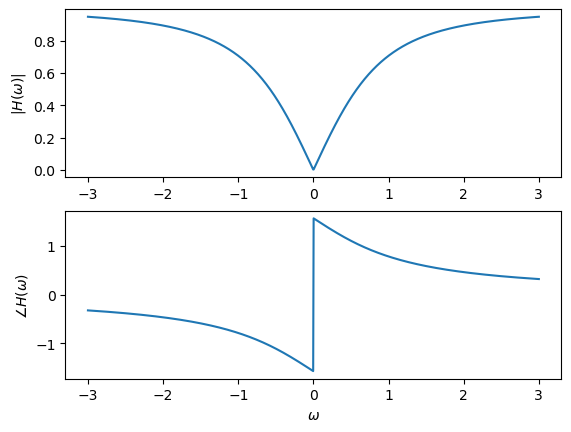

In [11]:
# Generate plots of magnitude and phase response for range of frequency values
wv = np.linspace(-3,3,1000)  # frequencies
Hv = rchighpass_fresp(wv,RC)  # frequency response values

plt.subplot(2,1,1)
plt.plot(wv,abs(Hv));
plt.ylabel('$|H(\omega)|$')

plt.subplot(2,1,2)
plt.plot(wv,np.angle(Hv));
plt.ylabel('$\\angle H(\omega)$')

plt.xlabel('$\omega$');

***

For an LTI system defined by the frequency response function $H(\omega)$, the response to the signal $e^{j \omega_0 t}$ will be $H(\omega_0) e^{j \omega_0 t}$.

Suppose we drive the system given previously with an real-valued input $$x(t) = \cos(\omega_0 t).$$  Since this can be written as $x(t) = 1/2 e^{j \omega_0 t} + 1/2 e^{-j \omega_0 t}$, by linearity the output is given by $y(t) = 1/2 H(\omega_0) e^{j \omega_0 t} + 1/2 H(-\omega_0) e^{-j \omega_0 t}$.  Noting now that for a real $h(t)$ we will have $H(\omega_0) = H^\ast(-\omega_0)$ we can do some algebraic manipulation to find that $$y(t) = |H(\omega_0)| \cos(\omega_0 t + \angle H(\omega_0)).$$

In the block of code below we consider various inputs of the form $x(t) = \cos(\omega_0 t) u(t)$, which effectively "start" at $t=0$.  We see that the output contains an initial transient after $t=0$ that is not sinusoidal, but that subsequently the output "settles" into the form of a sinusoid with some particular amplitude and phase shift relative to the input.  For any given frequency $\omega_0$ of input, this amplitude and phase is determined by $|H(\omega_0)|$ and $\angle H(\omega_0)$.

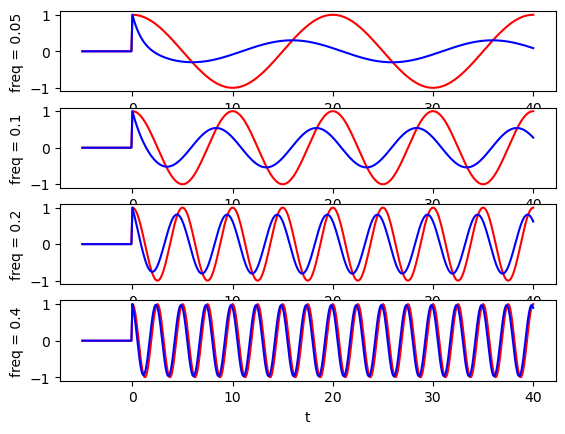

In [12]:
# Generate plots of input and output for cosines at different frequencies
RC = 1;
T = 0.1;  # smaller values give better approximation but more computation
tmin = -5;  tmax = 40  # range of time values for plots
nv = np.arange(np.floor(tmin/T),np.floor(tmax/T)+1)
tv = T*nv

fv = np.array([0.05,0.1,0.2,0.4])  # frequencies to plot (Hz)
for i in np.arange(0,len(fv)):
    freq = fv[i]
    xv = np.cos(2*np.pi*freq*tv);  xv[tv<0] = 0;  yv = rchighpass_resp(xv,0,0,RC,T)
    plt.subplot(len(fv),1,i+1)
    plt.plot(tv,xv,'r',tv,yv,'b');
    plt.ylabel('freq = ' + str(freq))
plt.xlabel('t');

Observe that as the frequency increases the amplitude of the output sinusoid approaches that of the input sinusoid, or in other words the gain approaches unity.  Also, for low frequencies there is a relative phase shift between output and input (the peaks of the input and output sinusoids are shifted relative to one another), while for high frequences this phase difference approaches zero.

***

To properly explore the relationship between the time and frequency representations we should consider the case of inputs and outputs being complex exponentials.  The block of code below is based on the previous case for cosine inputs, but with the input now the complex exponential signal $e^{j \omega_0 t}$ truncated to be right sided:
$$x(t) = e^{j \omega_0 t} u(t).$$
The approximate output can be calculated using `rchighpass_resp`, which should also work for complex-valued inputs.

After the initial transient after $t=0$ has died down the output should be
$$y(t) = H(\omega_0) e^{j \omega_0 t}.$$  Thus from the time-domain signals we can in this case estimate $H(\omega_0)$ by taking the ratio of $y(t)/x(t)$ for some large value of $t$.

Estimated frequency response value from last sample: 0.5396454407904687 * exp(1j*1.0325126046349875)
Actual frequency response value: 0.532018044501408 * exp(1j*1.0098142106862729)


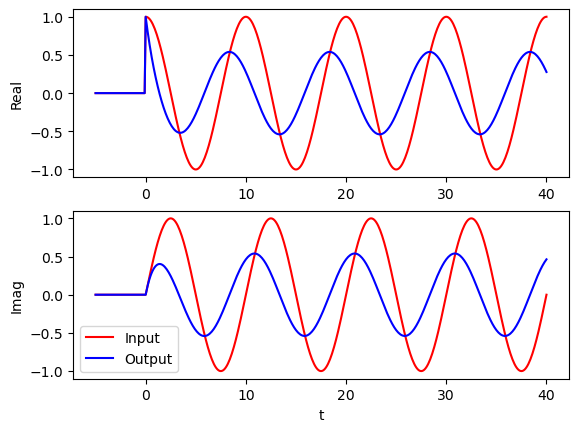

In [13]:
# Use time-domain signals to estimate frequency response for given w0
RC = 1;
T = 0.1;  # smaller values give better approximation but more computation
tmin = -5;  tmax = 40  # range of time values for plots
nv = np.arange(np.floor(tmin/T),np.floor(tmax/T)+1)
tv = T*nv

# Form signal values for right-sided complex exponential input
w0 = 2*np.pi*0.1
xv = np.exp(1j*w0*tv);  xv[nv<0] = 0
yv = rchighpass_resp(xv,0,0,RC,T)

# Plot input signal in red and output in blue (complex so real and imag plots)
plt.subplot(2,1,1)
plt.plot(tv,np.real(xv),'r',tv,np.real(yv),'b');  plt.ylabel('Real')
plt.subplot(2,1,2)
plt.plot(tv,np.imag(xv),'r',tv,np.imag(yv),'b');  plt.ylabel('Imag')
plt.xlabel('t')
plt.legend(['Input','Output'])

H0est = yv[-1]/xv[-1]  # approximate frequency response value from last signal sample
print('Estimated frequency response value from last sample: ' + str(np.abs(H0est)) + ' * exp(1j*' + str(np.angle(H0est)) + ')')
H0 = rchighpass_fresp(w0,RC)  # actual frequency response
print('Actual frequency response value: ' + str(np.abs(H0)) + ' * exp(1j*' + str(np.angle(H0)) + ')')

Use the time-domain method demonstrated in the previous code block to estimate the (complex) frequency response values of the system for each frequency value in the vector `wve`.  You should use the same `tmin` and `tmax` values and a discretisation interval of $T=0.1$.  The frequency response values must be assigned to corresponding elements of the output `Hve`.

In [ ]:
RC = 1
T = 0.1
tmin = -5;  tmax = 40  # range of time values for plots
nv = np.arange(np.floor(tmin/T),np.floor(tmax/T)+1)
tv = T*nv

wve = 2*np.pi*np.array([0.05,0.1,0.2,0.4])
Hve = np.zeros(wve.shape, dtype=complex)
for i in np.arange(0,len(wve)):
    
    Hve[i] = rchighpass_fresp(wve)

In [ ]:
grader.check("freqresprclp_q1c")

The code block below plots the `Hve` values just estimated as points on top of the actual frequency response $H(\omega)$.  The points should like roughly on the curve, with some error caused by the differential equation solution not being exact.  (Decreasing $T$ should make it more precise.)

In [ ]:
# Dense set of frequency response values for background plot
wvp = np.linspace(-3,3,1000)  # frequencies
Hvp = rchighpass_fresp(wvp,RC)  # frequency response values

plt.subplot(2,1,1)
plt.plot(wvp,abs(Hvp));
plt.plot(wve,abs(Hve),'r',linestyle="None",marker=".", markersize=20);
plt.ylabel('$|H(\omega)|$')

plt.subplot(2,1,2)
plt.plot(wvp,np.angle(Hvp));
plt.plot(wve,np.angle(Hve),'r',linestyle="None",marker=".", markersize=20);
plt.ylabel('$\\angle H(\omega)$')

plt.xlabel('$\omega$');

As expected for a highpass filter, frequencies in the vicinity of $\omega=0$ (low frequencies) are attenuated while high frequencies (positive and negative) are passed with little attenuation or phase shift.

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False, run_tests=True)